### Load Libraries and Check Version of TensorFlow Library

In [ ]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
plt.style.use('dark_background')
%matplotlib inline
import tensorflow as tf
tf.__version__

'2.15.0'

### Setting Printing Precision

In [ ]:
np.set_printoptions(precision=2)

### Load MNIST Data and Train Test Splitting

In [ ]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.transpose(1, 2, 0)
X_test = X_test.transpose(1, 2, 0)
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])

num_labels = len(np.unique(y_train))
num_features = X_train.shape[0]
num_samples = X_train.shape[1]

# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train).T
Y_test = tf.keras.utils.to_categorical(y_test).T


# Normalize the samples (images)
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)

print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))
print('Shape of the X_train Matrix is:', X_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10
Shape of the X_train Matrix is: (784, 60000)


### A generic layer class with forward and backward methods

In [ ]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass

  def backward(self, output_gradient, learning_rate):
    pass

### Define the loss function and its gradient

In [ ]:
def cce(Y, Yhat):
  return(np.mean(np.sum(-Y*np.log(Yhat), axis = 0)))
  #TensorFlow in-built function for categorical crossentropy loss
  #cce = tf.keras.losses.CategoricalCrossentropy()
  #return(cce(Y, Yhat).numpy())

def cce_gradient(Y, Yhat):
  return(-Y/Yhat)

### Define The Activation Layer and Its Forward and Backward Method

In [ ]:
class Activation(Layer):
    def __init__(self, activation, activation_gradient):
        self.activation = activation
        self.activation_gradient = activation_gradient

    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return(self.output)

    def backward(self, output_gradient, learning_rate = None):
        return(self.activation_gradient(self.input) * output_gradient[:-1, :])

### Specific activation layer classes:
* Signoid Activation Function
* Tanh Activation Function
* ReLU Activation Function

In [ ]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(z):
            return 1 / (1+np.exp(-z))

        def sigmoid_gradient(z):
            a = sigmoid(z)
            return a * (1-a)

        super().__init__(sigmoid, sigmoid_gradient)

class Tanh(Activation):
    def __init__(self):
        def tanh(z):
            return np.tanh(z)

        def tanh_gradient(z):
            a = np.tanh(z)
            return (1-(a**2))

        super().__init__(tanh, tanh_gradient)

class ReLU(Activation):
    def __init__(self):
        def relu(z):
            return z * (z > 0)

        def relu_gradient(z):
            return 1. * (z > 0)

        super().__init__(relu, relu_gradient)

In [ ]:
# What the SoftMax Function is doing Interbally
z = np.array([[10., 20., 30.], [-10., 50., 45.]]) # By giving a '.', convert them in flosting type values
print(z)
tf.nn.softmax(z, axis = 0).numpy()

[[ 10.  20.  30.]
 [-10.  50.  45.]]


array([[1.00e+00, 9.36e-14, 3.06e-07],
       [2.06e-09, 1.00e+00, 1.00e+00]])

### Softmax activation layer class and Its Forward and Backward Method


In [ ]:
class Softmax(Layer):
  def forward(self, input):
    self.output = tf.nn.softmax(input, axis = 0).numpy()

  def backward(self, output_gradient, learning_rate = None):
    ## Following is the inefficient way of calculating the backward gradient
    softmax_gradient = np.empty((self.output.shape[0], output_gradient.shape[1]), dtype = np.float64)
    for b in range(softmax_gradient.shape[1]):
      softmax_gradient[:, b] = np.dot((np.identity(self.output.shape[0])-np.atleast_2d(self.output[:, b])) * np.atleast_2d(self.output[:, b]).T, output_gradient[:, b])
    return(softmax_gradient)
    ## Following is the efficient way of calculating the backward gradient
    #T = np.transpose(np.identity(self.output.shape[0]) - np.atleast_2d(self.output).T[:, np.newaxis, :], (2, 1, 0)) * np.atleast_2d(self.output)
    #return(np.einsum('jik, ik -> jk', T, output_gradient))

### Dense layer class and Its Forward and Backward Method


In [16]:
class Dense(Layer):
    def __init__(self, input_size, output_size, reg_strength = 0.0):
        self.weights = 0.01*np.random.randn(output_size, input_size + 1) # bias trick
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
        self.reg_strength = reg_strength
        self.reg_loss = None

    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
        # Calculate the regularization loss (L2 regularization)
        self.reg_loss = self.reg_strength * np.sum(self.weights[:, :-1] * self.weights[:, :-1])

    def backward(self, output_gradient, learning_rate):
        ## Following is the inefficient way of calculating the backward gradient
        weights_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
        for b in range(output_gradient.shape[1]):
          weights_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:, b].reshape(-1, 1).T)
        weights_gradient = (1/output_gradient.shape[1])*weights_gradient

        # Add the regularization loss gradient here
        weights_gradient += 2*self.reg_strength * np.hstack([self.weights[:, :-1], np.zeros((self.weights.shape[0], 1))])

        ## Following is the efficient way of calculating the weights gradient
        #weights_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)

        input_gradient = np.dot(self.weights.T, output_gradient)

        # Update weights using gradient descent step
        self.weights = self.weights + learning_rate * (-weights_gradient)

        return(input_gradient)

### Function to generate sample indices for batch processing according to batch size

In [18]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)

### Example generation of batch indices

In [19]:
## Example generation of batch indices
batch_size = 8
batch_indices = generate_batch_indices(32, batch_size)
print(batch_indices)

[array([20, 25,  8,  7, 16, 23, 30,  3]), array([19,  6,  4, 24, 27, 29, 13,  2]), array([12,  9, 21, 10, 31, 11,  0,  5]), array([15, 14, 17, 26, 28,  1, 22, 18])]


### Train the 2-layer neural network (128 nodes in the hidden layer) using batch training with batch size = 100

In [22]:
## Train the 2-layer neural network (128 nodes in the hidden layer)
## using batch training with batch size = 100
learning_rate = 1e-3 # learning rate
batch_size = 100 # batch size
nepochs = 50 # number of epochs
reg_strength = 0 # regularization strength

# Create empty array to store training losses over each epoch
loss_train_epoch = np.empty(nepochs, dtype = np.float64)

# Create empty array to store test losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64)

# Define neural network architecture
dlayer1 = Dense(num_features, 128, reg_strength) # define dense layer 1
alayer1 = ReLU() # define activation layer 1
dlayer2 = Dense(128, num_labels, reg_strength) # define dense layer 2
softmax = Softmax() # define softmax activation layer

# Steps: run over each batch, calculate average loss, average gradient of loss,
# and update weights.

epoch = 0
while epoch < nepochs:
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  # Run over each batch
  for b in range(len(batch_indices)):
    # Forward prop starts here
    dlayer1.forward(X_train[:, batch_indices[b]])
    alayer1.forward(dlayer1.output)
    dlayer2.forward(alayer1.output)
    softmax.forward(dlayer2.output)

    # Calculate training data loss
    loss += cce(Y_train[:, batch_indices[b]], softmax.output)
    loss += dlayer1.reg_loss + dlayer2.reg_loss

    # Backward prop starts here
    grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
    grad = softmax.backward(grad)
    grad = dlayer2.backward(grad, learning_rate)
    grad = alayer1.backward(grad)
    grad = dlayer1.backward(grad, learning_rate)

  # Calculate the average training loss for the current epoch
  loss_train_epoch[epoch] = loss / len(batch_indices)

  # Forward propagation for the test data
  dlayer1.forward(X_test)
  alayer1.forward(dlayer1.output)
  dlayer2.forward(alayer1.output)
  softmax.forward(dlayer2.output)

  # Calculate the test data loss for the current epoch
  loss_test_epoch[epoch] = cce(Y_test, softmax.output) + dlayer1.reg_loss + dlayer2.reg_loss

  print('Epoch %d: train loss = %f, test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
  epoch = epoch + 1

Epoch 1: train loss = 2.298704, test loss = 2.294219
Epoch 2: train loss = 2.289447, test loss = 2.283279
Epoch 3: train loss = 2.276365, test loss = 2.267052
Epoch 4: train loss = 2.256376, test loss = 2.241882
Epoch 5: train loss = 2.225171, test loss = 2.202683
Epoch 6: train loss = 2.177267, test loss = 2.143544
Epoch 7: train loss = 2.107005, test loss = 2.059170
Epoch 8: train loss = 2.010345, test loss = 1.946843
Epoch 9: train loss = 1.886774, test loss = 1.808589
Epoch 10: train loss = 1.741350, test loss = 1.653062
Epoch 11: train loss = 1.585487, test loss = 1.494626
Epoch 12: train loss = 1.433321, test loss = 1.346681
Epoch 13: train loss = 1.295570, test loss = 1.216873
Epoch 14: train loss = 1.176615, test loss = 1.106718
Epoch 15: train loss = 1.076172, test loss = 1.014386
Epoch 16: train loss = 0.991915, test loss = 0.936977
Epoch 17: train loss = 0.921062, test loss = 0.871798
Epoch 18: train loss = 0.861163, test loss = 0.816605
Epoch 19: train loss = 0.810143, test

### Plot train and test loss as a function of epoch

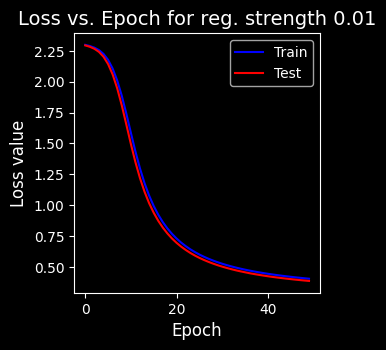

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
fig.tight_layout(pad = 4.0)
ax.plot(loss_train_epoch, 'b', label = 'Train')
ax.plot(loss_test_epoch, 'r', label = 'Test')
ax.set_xlabel('Epoch', fontsize = 12)
ax.set_ylabel('Loss value', fontsize = 12)
ax.legend()
ax.set_title('Loss vs. Epoch for reg. strength 0.01', fontsize = 14);

### Test performance on test data
Forward Propagation Using the Weights from the Last Epoch and Predicting the Output Lables for the Test data

In [24]:
## Forward propagate using the weights from the last epoch
dlayer1.forward(X_test)
alayer1.forward(dlayer1.output)
dlayer2.forward(alayer1.output)
softmax.forward(dlayer2.output)

# Predict the output labels for the test data
ypred = np.argmax(softmax.output.T, axis = 1)
print(ypred)
ytrue = np.argmax(Y_test.T, axis = 1)
print(ytrue)
np.mean(ytrue == ypred)

[7 2 1 ... 4 5 6]
[7 2 1 ... 4 5 6]


0.8973

### Confusion Matrix: Used to know how the model performs on unseen test data
* sklearn's metrics module is used to create the confusion matrix
* It has a function  called confusion_matrix to create the matrix

In [25]:
# Creating Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(ytrue, ypred)

array([[ 955,    0,    5,    2,    0,    7,    9,    1,    1,    0],
       [   0, 1106,    0,    5,    0,    1,    4,    1,   18,    0],
       [  13,   11,  891,   17,   19,    1,   20,   16,   42,    2],
       [   4,    0,   22,  895,    1,   37,    2,   18,   25,    6],
       [   1,    4,    6,    1,  908,    1,   14,    1,    7,   39],
       [  18,    3,    6,   52,   12,  722,   25,   10,   35,    9],
       [  19,    3,   12,    1,   19,   18,  879,    0,    7,    0],
       [   6,   19,   28,    3,    9,    1,    0,  922,    6,   34],
       [   6,    9,   14,   27,   13,   35,   14,   11,  825,   20],
       [  11,    7,    5,   11,   51,   14,    0,   33,    7,  870]])